In [24]:
import pandas as pd
import numpy as np

import sklearn.datasets
from sklearn.metrics import confusion_matrix, classification_report
##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,8)

In [25]:
# Download and load the data
!pip install keras
import keras
import os

f_path_1 = "data/diabetes.csv"
url_1 = "https://github.com/AkeemSemper/ml_data/raw/main/diabetes.csv"
if not os.path.exists(f_path_1):
    file_1 = keras.utils.get_file(f_path_1, url_1)
df1 = pd.read_csv(f_path_1)

f_path_2 = "data/titanic_train.csv"
url_2 = "https://github.com/AkeemSemper/ml_data/raw/main/titanic_train.csv"
if not os.path.exists(f_path_2):
    file_2 = keras.utils.get_file(f_path_2, url_2)
df2 = pd.read_csv(f_path_2)
df3 = pd.read_csv(f_path_2)

f_path_3 = "data/Assessments.csv.zip"
url_3 = "https://github.com/AkeemSemper/ml_data/raw/main/Assessments.csv.zip"
if not os.path.exists(f_path_3):
    file_3 = keras.utils.get_file(f_path_3, url_3)
df_ = pd.read_csv(f_path_3)

# Pipelines

Sklearn provides a tool for stiching together some of the data preprocessing steps that go into preparing our data, such as encoding categorical variables and rescaling numerical varaibles - the pipeline. 

The pipeline is concpetually pretty simple, we are just doing the same steps that we'd normally do to perform these data-prep functions. Probably the most challenging change is that the pipeline is more abstract - we don't see each step explicitly laid out, we set them all up and then just get results back. For this reason, it is important that we're comfortable with the ideas as there are fewer steps where we can troubleshoot. 

The basic process for using a pipeline is:
<ul>
<li>Create the pipeline object, which is imported from sklearn. 
<li>Set each preparation step, and the model step as arguments when making the pipeline. 
<li>Fit the pipeline object (instead of the model) with the data. (The pipeline roughly takes the place of the model)
<li>Score and predict with the pipeline object. 
<li>Documentation is here: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html 
</ul>

For example, we will take our dataset and rescale variables, before using a tree classifier

In [26]:
#Simple Pipeline
df1.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


We have a categorical target and some numerical features. 

The pipeline will be to rescale the features, then train the model. 

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

#Split data as normal
y = np.array(df1["Outcome"]).reshape(-1,1)
X = np.array(df1.drop(columns={"Outcome"}))
X_train, X_test, y_train, y_test = train_test_split(X, y)

#Build pipeline
pipeline_steps = [
    ('scaler', StandardScaler()),
    ('DT', DecisionTreeClassifier())
    ]

pipe = Pipeline(pipeline_steps)
# The pipeline can be used as any other estimator

pipe.fit(X_train, y_train)

pipe.score(X_test, y_test)

0.7239583333333334

Voila! Clean and simple!

We could do the exact same thing with encoding if we had categorical varaibles. 

In [28]:
df2.drop(columns={"PassengerId", "Name", "Ticket", "Fare", "Cabin", "Age", "SibSp", "Parch"}, inplace=True)
df2.head()

,Survived,Pclass,Sex,Embarked
0,0,3,male,S
1,1,1,female,C
2,1,3,female,S
3,1,1,female,S
4,0,3,male,S


In [29]:
for i in df2.columns:
    df2[i] = df2[i].astype('category')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    category
 1   Pclass    891 non-null    category
 2   Sex       891 non-null    category
 3   Embarked  889 non-null    category
dtypes: category(4)
memory usage: 4.1 KB


In [30]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

#Split data as normal
y = np.array(df2["Survived"]).reshape(-1,1)
X = np.array(df2.drop(columns={"Survived"}))
X_train, X_test, y_train, y_test = train_test_split(X, y)

#Build pipeline
pipeline_steps = [
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder()),
    ('DT', DecisionTreeClassifier())
    ]

pipe = Pipeline(pipeline_steps)
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
pipe.fit(X_train, y_train)

pipe.score(X_test, y_test)

0.7713004484304933

## Combined Variable Types

One thing we didn't handle "properly" above was the numerical values, we just dropped them. In order to deal with feature sets that have both categorical (requires encoding) and numerical (requires scaling) we need to use something slightly more complex - the Column Transformer. 

Our data processing pipeline will usually need to involve several different steps on several different features, some may need to be encoded, others may need to be scaled, and others may need to have missing values dealt with. The Column Transformer is a tool that allows us to split our data processing pipeline into several different paths, and send the appropriate subset of data into each of those paths. 

We'll look at how we can use a column transformer after a quick detour into one thing we commonly want to use inside of one, imputation...

### Imputation

One common thing that we need to deal with in processing data for modelling is to handle data that is missing, and extending from the idea of the column transformer it is common that for different features we may need to deal with those missing values differently. Until now we have dealt with any missing data by just deleting the row, so there are no missing values; this action is a simplified version of a process called imputation. Imputation is the general process of filling in missing values. In this data we can see from the Describe that there are 891 rows, but under Age there are some missing values. We could delete these rows, or we could <b><i>impute</i><b> a value to insert as a placeholder - or generate a value to plug in, replacing the missing value. This allows us to keep those rows that have a missing value. 

Imputation is a very common data preparation step, it takes blank data and "deals with it". Dealing with it may mean removing those blanks, or using some more advanced analysis to determine a placeholder value to insert. 

In [31]:
df3.drop(columns={"PassengerId", "Name", "Ticket", "Cabin"}, inplace=True)
df3.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [32]:
df3.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


### Imputation Considerations

The positive to doing this imputation is that we don't loose data. In many real world scenarios we often have some data that is missing. Think about a scenario where we are attempting to predict if people will get skin cancer - our features may be things like where they live, sun exposure, outdoor jobs, tanning, race/skin color, medical info, etc... In a real world study it is pretty difficult to gather a large dataset where every useful feature can be captured for every row in the dataset. Deleting every row where we have any missing value would likely cut our large, and hard and expensive to gather data, down to a shell of itself - if we did a large cancer study that spanned years, we probably wouldn't want to delete patients if they failed to complete one survey question. By imputing those missing values we can keep our valuable data by plugging in some placeholder for those occasional missing spots. 

For this example, we are plugging in an average (mean) age for the rows of Titanic-ers for which we have no age. This seems somewhat reasonable based on intuition - if there is some random passenger and we have no idea of their age, but we assume they are ~30, that probably doesn't mess things up too dramatically. There's a possibility that they are really old and we are way off, but the 75% percentile is 38, so the odds of that are pretty low. Overall we are probably 'winning' by keeping all that other data by using the imputation of age. 

The negative is that we are literally inventing a new value, and plugging it in - we are making up fake data. This can obviously introduce error if we do it poorly. For example, assume we are examining stock market data to predict stock price increases, to determine if we should invest. Imputing profitability (earnings per share) may not be super logical in this scenario. 

#### Why is it Missing?

One key consideration in the real world in doing imputation is examining why the data is missing. Is the data just randomly missing, or is there some reason why some values may be missing?

For example, survey data that involves people self-identifying with/as something that may incur discrimination (lgbt, race, disability, age) are commonly underidentified. Collecting data may be more challenging in remote environments vs cities. Forms may be poorly laid out, leading to one question being consistently overlooked. 

There are a lot of reasons that values may be missing, and examination with domain knowledge will help us determine the most appropriate imputation strategy. We will look at more sophisticated imputation stuff later on. 

#### Imputation Overall and Initial Strategy

Imputation is extremely common in machine learning. In the smaller test datasets that we often use it isn't as important, as these tend to be more complete. In real world scenarios, especially when data is hard to collect (e.g. census, suveys, etc...), it is pretty common and often required to maintain the usability of our datasets. 

#### Imputation Approach

For now, we can focus on simple imputation:

<ul>
<li>Numerical Imputation:
<ul>
<li>Replace with median: If we want to maintain median - outliers, skewed distributions such as income. 
<li>Replace with mean: If we want to maintain mean - normal(ish) distributions such as height. 
</ul>
<li>Categorical Imputation:
<ul>
<li>Replace with mode (most common value)
</ul>
<li>Either:
<ul>
<li>If there is some default value, we can fill with a constant. For example, if you have data on number of citizenships that people have, the vast majority have 1. It makes sense to impute 1 if that data is missing (in this case that's the mode). 
</ul>
</ul>

There are several more complex imputation techniques that can be used, we'll look at some briefly when we look at clustering. The basic idea behind all of them is that they seek to impute a value that is "better" than one of the simple guesses by using the other data to come up with a more targeted value to impute. For example, if we were imputing a value for someone's income, and we knew their profession, it would likely make sense to impute a different value for the income of a brain surgeon than for a parking lot attendant. 

One more consideration is the number of missing values in a column - if we are just imputing a huge percentage of the values for one of our features, that feature probably isn't helping us all that much. A rule of thumb is that if you're missing about 20%-30% of the values in a column it is better to just drop that column rather than impute values for it. This rule of thumb is pretty loose - it really requires a specific look at the data, mainly the reason that values are missing. If we can infer some meaning from what's missing, we are more likely to be able to determine a logical imputation. In this Titanic example, Age is missing in a large number of rows, but keeping it is still worth it because the imputation is reasonable. 

Lastly, fillna in pandas also imputes similarly to what we are doing here. 

## Pipelines with Column Transformers

Our goal here is to create a pipleine to do the following:
<ul>
<li>Impute missing numeric values with the mean. 
<li>Scale numeric values with a standard scaler. 
<li>Encode categorical values.
<li>Model with a decision tree. 
</ul>

The column transformer object allows us to split the features that we are processing and deal with each group separately, this is very common in situations where we have both numeric and categorical variables to prepare - the numeric varaibles can be scaled, the categorical ones can be encoded, then they can be recombined into our prepared dataset.

![Column Transformer](images/col_trans.png "Column Transformer")

### Using a Column Transformer

A column transformer functions like a slightly more elaborate pipeline:
<ul>
<li> The column transformer takes in multiple data subsets, and preprocessing pipelines. 
    <ul>
    <li> Each argument in creating the CT contains 3 things - an informal label, the columns to process, and a pipeline of the processing steps. 
    </ul>
<li> Each subset flows through the supplied processing pipeline. 
<li> At the end, the data is recombined, and the data is spit out ready for modelling. 
<li> In general, when using a column transformer, we will have:
    <ul> 
    <li> A column transformer that is effectively "the preprocessing pipeline". 
    <li> Within that transformer, a pipeline that deals with each distinct subset of data (usually one for categorical, one for numerical).
    <li> Another pipeline with two steps - the column transformer and the model, this is what we call "fit" on. 
    </ul>
</ul>
<b>Note:</b> we can split the columns into our groups in the column transformer either by manual inspection, or by some automatic filter like the data type. If you're automating it, make sure that you can trust that the data types are trustworthy - something like a rouge "n/a" in a numerical column could mess everything up. Some commands that can get the data types are df.dtypes, df.select_dtypes, and df.columns.

This all sounds a bit complex, but it isn't much worse than setting up a pipeline, here we've just layered in another step and we need to split the data into subsets. The steps like fit and score that we are used to with pipelines or models all work the same once the column transformer is established. 

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

numeric_features = ["Age", "Fare", "SibSp", "Parch"]
numeric_transformer = Pipeline( steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

categorical_features = ["Embarked", "Sex", "Pclass"]
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer( transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ])

Now that the column transformer is created, putting it to use is a familiar process. 

In [34]:
#Split data as normal
y = df3["Survived"]
X = df3.drop(columns={"Survived"})

#Build pipeline
pipeline_steps = [('pre', preprocessor),('DT', DecisionTreeClassifier()) ]
pipe = Pipeline(pipeline_steps)

X_train, X_test, y_train, y_test = train_test_split(X, y)
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7668161434977578

#### Combining Pipeline Objects

As you may have picked up on, there's a lot of interchangeability between the sklearn objects that we use to prepare and model data. This is generally good, as we can arrange the exact pieces that we need and they'll work together in almost any combination. This can also be a little confusing, as there's not one fixed way to do things. In the long run, we'll get more used to this and be able to use it to our advantage - as long as something fits the template of these preprocessing tools (there are specific classes to extend, we'll look at it a little more later on) we can plug and play different preprocessing items, and even create our own. 

The ability to swap things in and out will be useful soon when we look at a grid search - the interchangability of steps helps allow us to automate the running of different trials to see what is most accurate. 

## Exercise - Predict the Target

Think about processing the different types of data, how to deal with missing values, and how to encode the categorical variables.

<b>Note:</b> the OneHotEncoder is used to encode the categorical variables in a pipeline.

In [35]:
def makeReadyToImpute(df_):
    # Calculate the number of cells in the DataFrame
    num_cells = df_.size
    # Calculate 10% of the number of cells
    num_del = int(num_cells * 0.1)
    # Create a DataFrame of the same shape as df_ and fill it with True values
    mask = pd.DataFrame(True, index=df_.index, columns=df_.columns)
    # Select a random sample of cells
    cells_to_del = mask.stack().sample(n=num_del).index
    # Set the selected cells to NaN
    for idx in cells_to_del:
        df_.at[idx] = np.nan
    return df_
#df_ = pd.read_csv("data/Assessments.csv")
#df_.rename(columns={"Garage":"target"}, inplace=True)
targets = np.where(df_["Garage"] == "Y", 1, 0)
df_.drop(columns={"Garage"}, inplace=True)
df_ = makeReadyToImpute(df_)
df_["target"] = targets
df_["target"].dropna(inplace=True)
df_.head()

,Account Number,Suite,House Number,Street Name,Neighbourhood ID,Neighbourhood,Ward,Assessed Value,Latitude,Longitude,target
0,1066158.0,NaN,14904.0,167 AVENUE NW,NaN,NaN,NaN,86000.0,53.630497,-113.580474,0
1,10508233.0,NaN,16340.0,NaN,NaN,NaN,NaN,45000.0,53.617335,-113.605690,0
2,NaN,NaN,15617.0,83 STREET NW,2050.0,BELLE RIVE,NaN,285000.0,53.617007,-113.467976,0
3,1034214.0,NaN,10661.0,161 AVENUE NW,3040.0,BEAUMARIS,Ward 3,NaN,53.619978,NaN,1
4,NaN,NaN,15003.0,76 AVENUE NW,4430.0,RIO TERRACE,NaN,407500.0,53.508644,-113.579897,1


In [36]:
df_.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384217 entries, 0 to 384216
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account Number    345635 non-null  float64
 1   Suite             72051 non-null   object 
 2   House Number      307842 non-null  float64
 3   Street Name       307972 non-null  object 
 4   Neighbourhood ID  346159 non-null  float64
 5   Neighbourhood     345574 non-null  object 
 6   Ward              345967 non-null  object 
 7   Assessed Value    345520 non-null  float64
 8   Latitude          345942 non-null  float64
 9   Longitude         345764 non-null  float64
 10  target            384217 non-null  int64  
dtypes: float64(6), int64(1), object(4)
memory usage: 32.2+ MB


In [37]:
df_ = df_.drop(columns=(["Street Name", "Account Number", "House Number", "Neighbourhood", "Neighbourhood ID"]))
df_.head()

,Suite,Ward,Assessed Value,Latitude,Longitude,target
0,NaN,NaN,86000.0,53.630497,-113.580474,0
1,NaN,NaN,45000.0,53.617335,-113.605690,0
2,NaN,NaN,285000.0,53.617007,-113.467976,0
3,NaN,Ward 3,NaN,53.619978,NaN,1
4,NaN,NaN,407500.0,53.508644,-113.579897,1


In [38]:
df_["hasSuite"] = df_["Suite"].isna().astype(bool)
df_["hasSuite"].fillna(0, inplace=True)
df_.drop(columns={"Suite"}, inplace=True)
df_.sample(20)

,Ward,Assessed Value,Latitude,Longitude,target,hasSuite
143547,Ward 11,340000.0,53.503159,-113.483472,1,True
262195,Ward 12,435000.0,53.427421,-113.431653,1,True
63092,Ward 7,99500.0,53.561739,-113.450853,0,False
254680,NaN,524500.0,53.451800,-113.388980,1,True
224155,Ward 1,87000.0,53.542530,-113.587295,0,False
176895,Ward 8,416000.0,53.529049,-113.450422,1,True
160395,Ward 8,434000.0,53.525838,-113.438673,1,True
574,Ward 4,288000.0,53.609735,-113.397597,1,True
50213,Ward 6,107000.0,53.542024,-113.525508,0,False
375867,Ward 1,307500.0,53.516812,-113.696457,1,False


### Create Column Transformer and Model

Try to swap out a model, or some of the other steps, and see how different the results are.

Test score: 0.9321014002394461


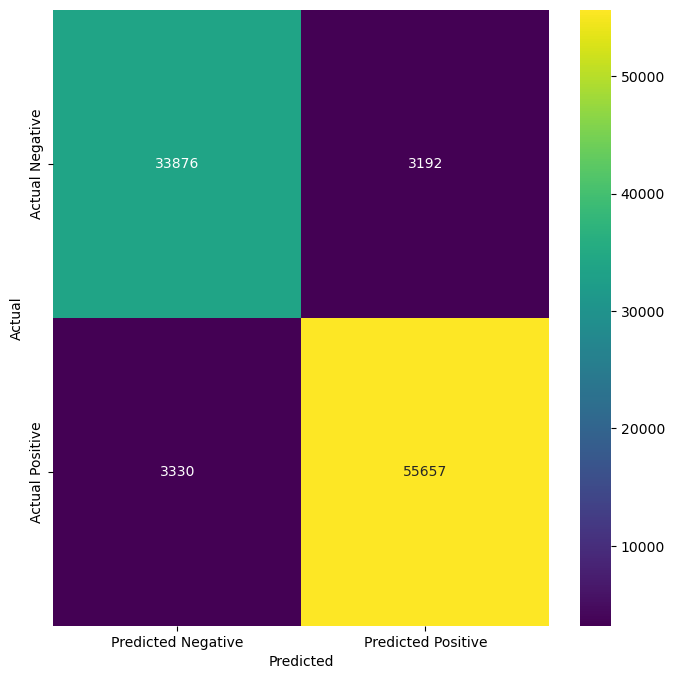

In [39]:
numeric_features_ = ["Assessed Value", "Latitude", "Longitude"]
numeric_transformer_ = Pipeline( steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

categorical_features_ = ["Ward", "hasSuite"]
categorical_transformer_ = Pipeline( steps=[
    ("impute_mode", SimpleImputer(strategy="most_frequent")),
    ("encode", OneHotEncoder())
])

preprocessor_ = ColumnTransformer( transformers=[
        ("num", numeric_transformer_, numeric_features_),
        ("cat", categorical_transformer_, categorical_features_),
    ])

#Split data as normal
#y = np.array(df3["Survived"]).reshape(-1,1)
#X = np.array(df3.drop(columns={"Survived"}))
y_ = df_["target"]
X_ = df_.drop(columns={"target"})

#Build pipeline
pipeline_steps_ = [('pre', preprocessor_),('DT', DecisionTreeClassifier()) ]
pipe_ = Pipeline(pipeline_steps_)

X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_)
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set

pipe_.fit(X_train_, y_train_)
print("Test score:", pipe_.score(X_test_, y_test_))

# Get predictions
y_pred_ = pipe_.predict(X_test_)

# Create confusion matrix
conf_mat = confusion_matrix(y_test_, y_pred_)

# Create heatmap
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="viridis", 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## k-Nearest Neighbors - kNN

<b>Big Note:</b> The knn imputation here relates to some clustering concepts we'll see a bit later, the basic concept is relatively simple.

k-Nearest Neighbors, or kNN, is a <b>supervised</b> machine learning algorithm that we can use for both regression and classification. This <b>is not</b> the same as k-means clustering nor is it directly related, it is conceptually similar though, so we'll take a quick peek at it here. We won't examine kNN in depth. 

The basic idea of kNN is that things that are similar are "close" to each other. The algorithm functions like this:

<ol>
<li> Select the number K of the neighbors
<li> Calculate the Euclidean distance of K number of neighbors
<li> Take the K nearest neighbors as per the calculated Euclidean distance.
<li> Among these k neighbors, count the number of the data points in each category.
<li> Assign the new data points to that category for which the number of the neighbor is maximum.
<li> Our model is ready.
</ol>

![kNN](images/knn.png "kNN" )

Implementation in sklearn is pretty similar to other modelss. 

kNN is relatively simple, but can get slow with large volumes of data and is often surpassed in performance by other models, so we don't see it used all that much. 

In [40]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

model_knn_class = KNeighborsClassifier()
model_knn_reg = KNeighborsRegressor()

## kNN Imputation

One place where kNN is very useful is in doing imputation. When we have done imputation, we've gone with something simple, like the mean or median, or the mode for the most frequent value. This is easy, but has some obvious weaknesses. Suppose we are imputing something like income for census type data. Taking the median income for a random missing income value may be OK, but people tend to have pretty different incomes. What if instead of just taking the overall average, we took the average of the nearest neighbors - in this case potentially, literal neighbors. 

KNNImputer is an imputation method that does just that, each record will "find its neighbors" based on similarity on the other metrics, and that subset of records will be averaged and imputed. In this example, we may impute by finding people with similar location, home size, career, etc... and taking their average, which makes more sense intuitively and can often be more accurate. Using this smarter imputation will often improve our ability to make useful imputations when data is missing, the exact impact depends on the data, but it is something that is certainly worth a try. 

![KNN Imputation](images/knnImpute.png "KNN Imputation" )

In the image above, if we were imputing a class, we would take the most common class of the nearest neighbors inside that "K" circle. For a number, we'd average those records together. Another sklearn package, IterativeImputer, does a similar thing using regression. See sklearn documentation for details, use is simple, just like other imputers.

A demo of smarter imputation can be seen easily in a really simple example. The values in the <b>top right</b> and the <b>first row, 2nd from bottom</b> are imputed differently with each imputer. 

In [41]:
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer
nan = np.nan
X = [[1, 0, nan], [7, 4, 0], [nan, 8, 5], [9, 8, 7]]

<Axes: >

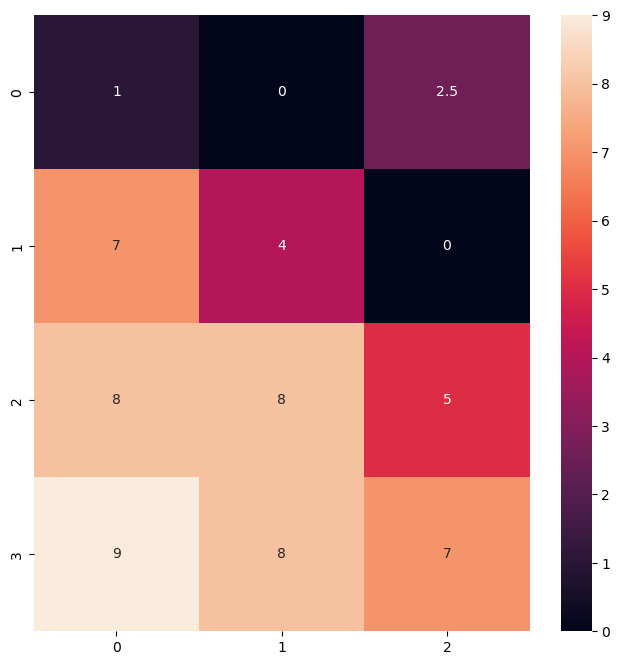

In [42]:
knn_imp = KNNImputer(n_neighbors=2, weights="uniform")
sns.heatmap(knn_imp.fit_transform(X), annot=True)

<Axes: >

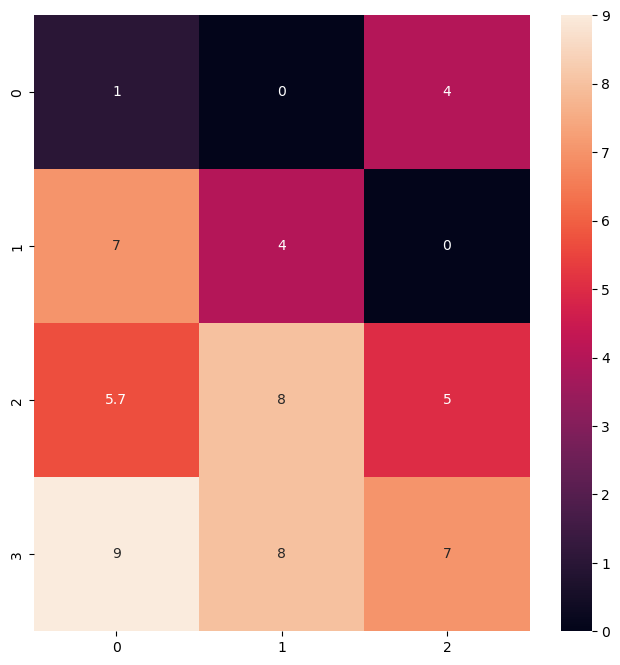

In [43]:
simp_imp = SimpleImputer()
sns.heatmap(simp_imp.fit_transform(X), annot=True)